# Computer Vision Project
## INSTANCE 22 Challenge

### Team
1. Shaurya Dewan - 2019101017
2. Ashwin Rao - 2019101049
3. Harshwardhan Prasad - 20

### Importing Required Libraries and Basic Setup

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, MaskedLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import time
import tqdm
import cv2

In [2]:
print_config()

MONAI version: 0.9.0rc1+19.g61a0dc35
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 61a0dc35b8a5edf78487b30c02c7aa0e51fc3409
MONAI __file__: /home/srd/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "./results"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./results


## Dataloader Setup

### Setting Datafiles' Paths

In [4]:
data_dir = "./data/train"
train_images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "label", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [5]:
set_determinism(seed=0)

### Definition of Data Transforms

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 48),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

### Testing with Basic Dataloader

Dataloader Batch Dimensions =  torch.Size([8, 1, 96, 96, 48])
Original Scan Shape = torch.Size([96, 96, 48]), 
Segmented Scan Shape = torch.Size([96, 96, 48])
Unique Segmentation Mask Values =  [0. 1.]
Index = 2, Scan = 18


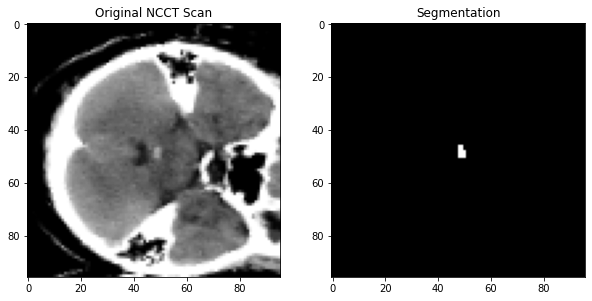

In [7]:
idx = 2
scan = 18

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2)
check_data = first(check_loader)
image, label = (check_data["image"][idx][0], check_data["label"][idx][0])

print("Dataloader Batch Dimensions = ", check_data["image"].shape)
print(f"Original Scan Shape = {image.shape}, \nSegmented Scan Shape = {label.shape}")
print("Unique Segmentation Mask Values = ", np.unique(label[:, :, scan]))

print("Index = %d, Scan = %d" % (idx, scan))
plt.figure("Testing", (10, 10))
plt.subplot(1, 2, 1)
plt.title("Original NCCT Scan")
plt.imshow(image[:, :, scan], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation")
plt.imshow(label[:, :, scan], cmap="gray")
plt.show()

### Train and Validation Dataloaders

In [8]:
train_batch_size = 4
val_batch_size = 1

# train_ds = Dataset(data=train_files, transform=train_transforms)
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=4)

# val_ds = Dataset(data=val_files, transform=val_transforms)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:02<00:00,  3.64it/s]


### Experimentation for ABC Loss

The primary issue we faced here is that for cases where there is more than 1 hemorrhage or more than 1 ROI in the mask, how do we find the scan with the largest area for each ROI separately and how many scans each respective ROI covers as the ABC/2 method would need to be applied separately for each ROI and thus the variables would need to be with respective to each ROI.

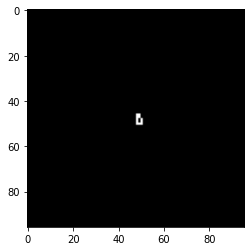

In [9]:
npImg = label.cpu().numpy()[:, :, scan:scan + 1].astype(np.uint8)
conts, hierarchy = cv2.findContours(npImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
border = np.zeros(npImg.shape)
for arr in conts[0]:
    border[arr[0][1], arr[0][0], 0] = 1
    
plt.imshow(border, cmap="gray")
plt.show()

Image 0 has 0 contours


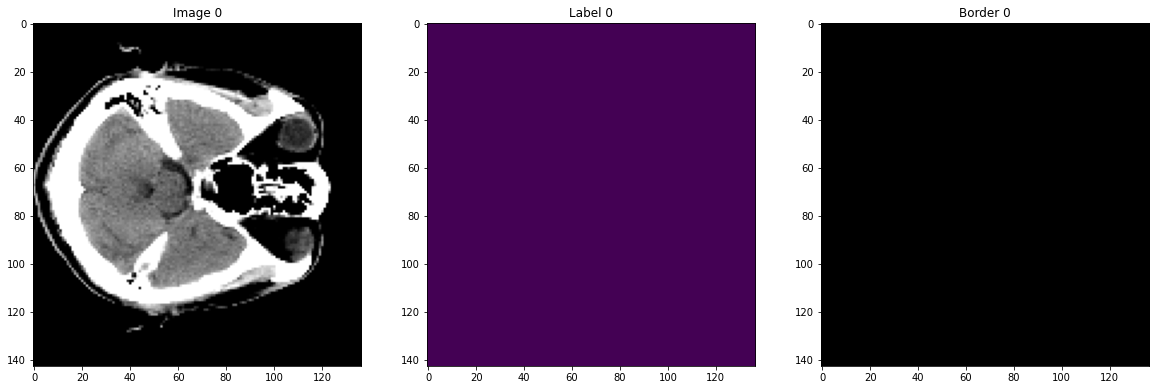

Image 1 has 1 contours
Max length = 7.211103,
 Max length index = 7,
 Length at min distance = 7.211103,

Min distance = 0.000000,
 Min distance index = 7,
 Distance at max length = 0.000000
Closest to perpendicular = 90.000000,
 Best perpendicular length = 7.211103



divide by zero encountered in int_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


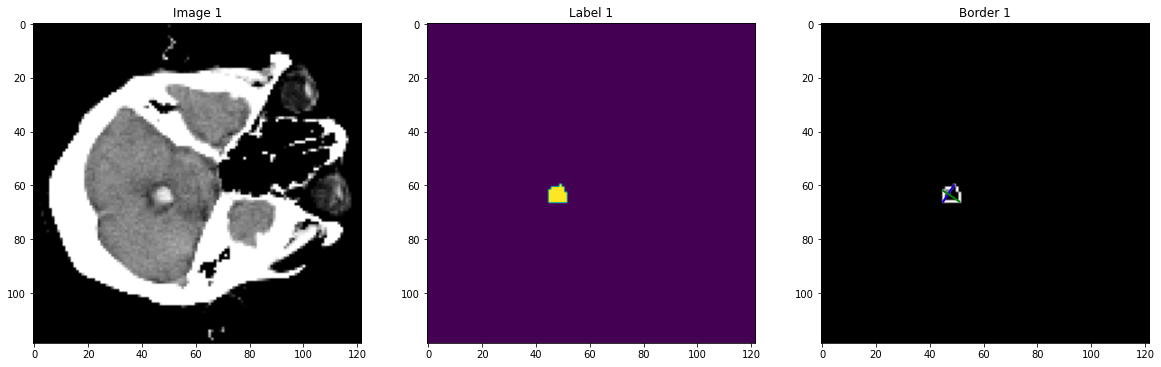

Image 2 has 0 contours


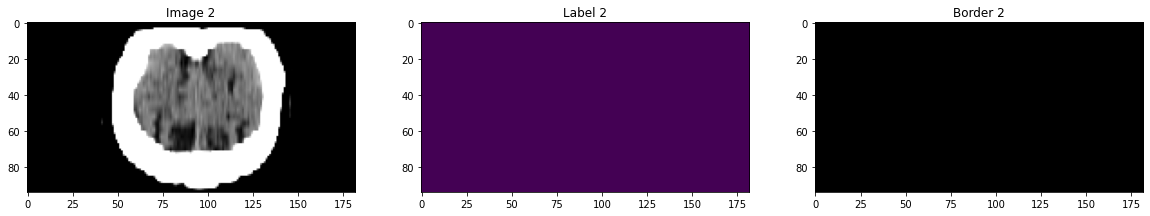

Image 3 has 3 contours
Max length = 18.439089,
 Max length index = 21,
 Length at min distance = 12.000000,

Min distance = 0.000000,
 Min distance index = 213,
 Distance at max length = 0.108465
Closest to perpendicular = 89.204276,
 Best perpendicular length = 7.810250

Max length = 20.000000,
 Max length index = 216,
 Length at min distance = 1.000000,

Min distance = 0.000000,
 Min distance index = 41,
 Distance at max length = 0.000000
Closest to perpendicular = 78.690068,
 Best perpendicular length = 5.099020



invalid value encountered in true_divide
invalid value encountered in int_scalars


Max length = 44.721360,
 Max length index = 836,
 Length at min distance = 4.123106,

Min distance = 0.000000,
 Min distance index = 21,
 Distance at max length = 4.203808
Closest to perpendicular = 89.157476,
 Best perpendicular length = 6.082763



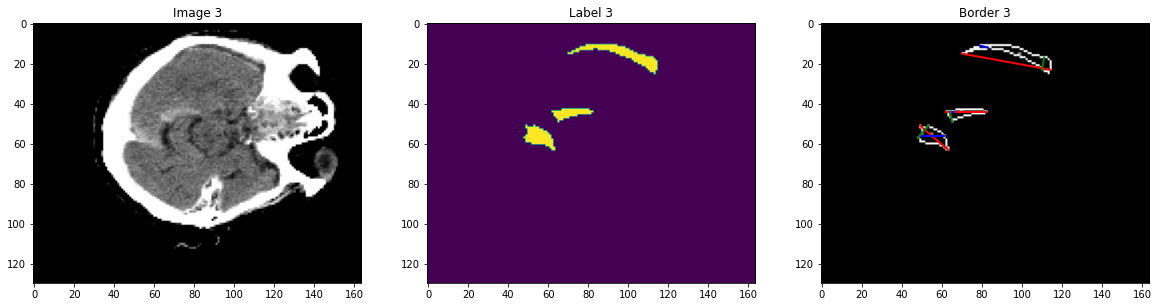

Image 4 has 0 contours


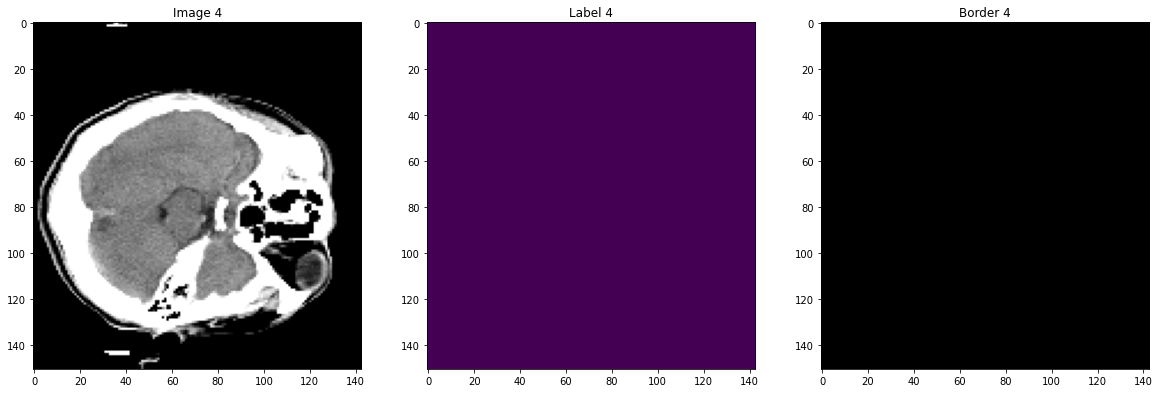

Image 5 has 0 contours


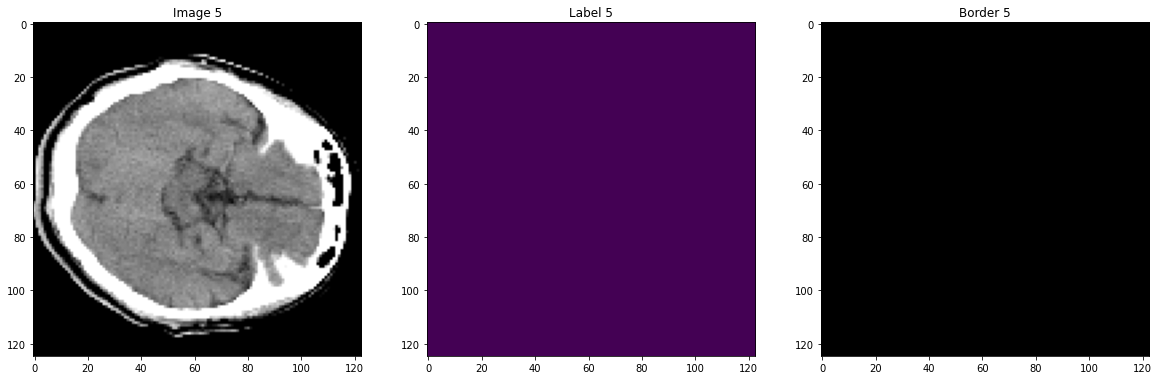

Image 6 has 2 contours
Max length = 45.343136,
 Max length index = 2582,
 Length at min distance = 19.416488,

Min distance = 0.000000,
 Min distance index = 17,
 Distance at max length = 1.587892
Closest to perpendicular = 87.236143,
 Best perpendicular length = 6.403124



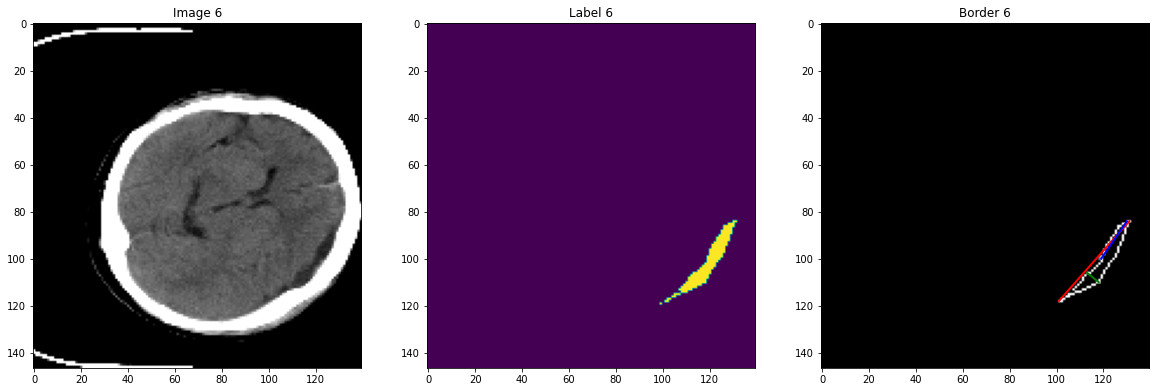

Image 7 has 1 contours
Max length = 8.602325,
 Max length index = 136,
 Length at min distance = 8.000000,

Min distance = 0.000000,
 Min distance index = 9,
 Distance at max length = 0.697486
Closest to perpendicular = 88.667780,
 Best perpendicular length = 5.000000



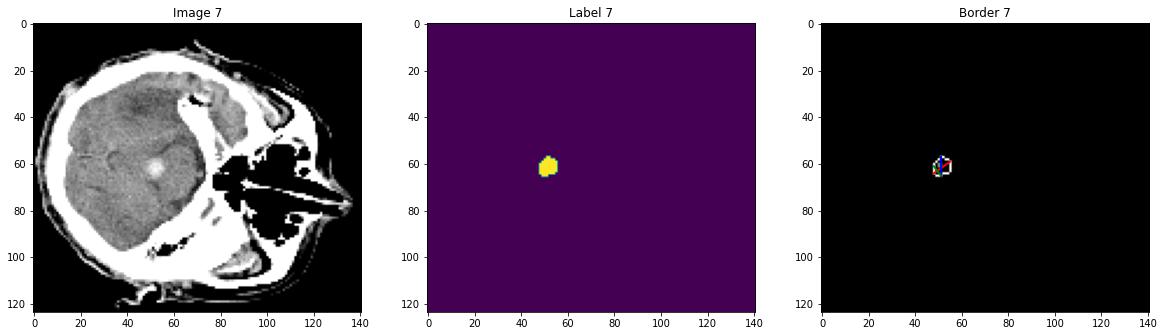

Image 8 has 1 contours
Max length = 6.324555,
 Max length index = 46,
 Length at min distance = 5.000000,

Min distance = 0.000000,
 Min distance index = 34,
 Distance at max length = 0.000000
Closest to perpendicular = 90.000000,
 Best perpendicular length = 3.162278



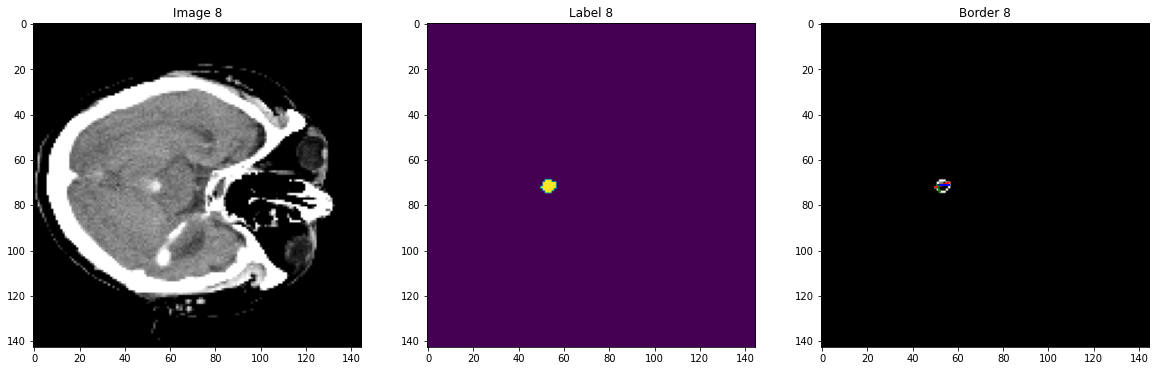

In [10]:
scan = 24

for i, val_data in enumerate(val_loader):
    plt.figure("Check", (20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image {i}")
    plt.imshow(val_data["image"][0, 0, :, :, scan], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title(f"Label {i}")
    plt.imshow(val_data["label"][0, 0, :, :, scan])

    plt.subplot(1, 3, 3)
    plt.title(f"Border {i}")

    label = val_data["label"][0, 0]
    npImg = label.cpu().numpy()[:, :, scan:scan + 1].astype(np.uint8)
    contours, hierarchy = cv2.findContours(npImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    border = np.zeros(npImg.shape)
    gap = 1
    lengths = []
    line_pts = []
    centroid_dists = []
    print("Image %d has %d contours" % (i, len(contours)))
    
    for fig in contours:
        lengths.append([])
        line_pts.append([])
        centroid_dists.append([])
        
        M = cv2.moments(fig)
        centroid = []
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            border[cy-gap:cy+gap, cx-gap:cx+gap, 0] = 0.5
            centroid = [cx, cy]

        if len(fig) < 10:
            continue
            
        for idx in range(len(fig)):
            coord = fig[idx][0]
            border[coord[1], coord[0], 0] = 1
            
            for next_idx in range(idx + 1, len(fig)):
                next_coord = fig[next_idx][0]
                line_pts[-1].append([[coord[0], next_coord[0]], [coord[1], next_coord[1]]])
                
                length = np.sqrt((next_coord[0] - coord[0]) ** 2 + (next_coord[1] - coord[1]) ** 2)
                lengths[-1].append(length)
                
                num = np.abs((next_coord[0] - coord[0]) * (coord[1] - centroid[1]) - (next_coord[1] - coord[1]) * (coord[0] - centroid[0]))
                centroid_dist = num / length
                if not length:
                    centroid_dist = np.inf
                centroid_dists[-1].append(centroid_dist)
        
        max_len = max(lengths[-1])
        max_len_idx = lengths[-1].index(max_len)
        min_dist = min(centroid_dists[-1])
        min_dist_idx = centroid_dists[-1].index(min_dist)
        print("Max length = %f,\n Max length index = %d,\n Length at min distance = %f,\n" % 
              (max_len, max_len_idx, lengths[-1][min_dist_idx]))
        print("Min distance = %f,\n Min distance index = %d,\n Distance at max length = %f" % 
              (min_dist, min_dist_idx, centroid_dists[-1][max_len_idx]))
        plt.plot(line_pts[-1][max_len_idx][0], line_pts[-1][max_len_idx][1], color="red", linewidth=2)
        plt.plot(line_pts[-1][min_dist_idx][0], line_pts[-1][min_dist_idx][1], color="blue", linewidth=2)
        
        [[x1, x2], [y1, y2]] = line_pts[-1][max_len_idx]
        max_len_slope = (y2 - y1) / (x2 - x1)
        best = np.inf
        best_idx = -1
        for idx in range(len(line_pts[-1])):
            if idx == max_len_idx:
                continue
            
            [[x1, x2], [y1, y2]] = line_pts[-1][idx]
            slope = (y2 - y1) / (x2 - x1)
            angle = np.arctan((slope - max_len_slope) / (1 + slope * max_len_slope))
            
            if np.abs(angle - np.pi / 2) < np.abs(best - np.pi / 2):
                best = angle
                best_idx = idx
            elif np.abs(angle - np.pi / 2) == np.abs(best - np.pi / 2) and lengths[-1][best_idx] < lengths[-1][idx]:
                best = angle
                best_idx = idx
                
        print("Closest to perpendicular = %f,\n Best perpendicular length = %f\n" % (best * 180 / np.pi, lengths[-1][best_idx]))
        plt.plot(line_pts[-1][best_idx][0], line_pts[-1][best_idx][1], color="green", linewidth=2)
    
    plt.imshow(border, cmap="gray")
    plt.show()

    if i == 10:
        break

In [11]:
def get_lines(contour, curr):
    coord = contour[curr]
    lines_pts = []
    lengths = []
    
    for next_idx in range(curr + 1, len(contour)):
        next_coord = contour[next_idx][0]
        lines_pts.append([[coord[0], next_coord[0]], [coord[1], next_coord[1]]])
        length = np.sqrt((next_coord[0] - coord[0]) ** 2 + (next_coord[1] - coord[1]) ** 2)
        lengths.append(length)
        
    return lines_pts, lengths

In [12]:
def get_contours(imgs):
    border_imgs = []
    contours_arr = []
    
    for i in range(len(imgs)):
        img = imgs[i, 0].cpu().numpy()
        border_img = np.zeros(img.shape)
        img_contours = []
    
        for idx in range(img.shape[-1]):
            scan = img[:, :, scan:scan + 1].astype(np.uint8)
            contours, hierarchy = cv2.findContours(scan, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            for j in range(len(contours)):
                contour = contours[j]
                lines_pts = []
                lengths = []
                
                for k in range(len(contour)):
                    coords = contour[k][0]
                    border_img[coords[1], coords[0], idx] = 1
                    
                    k_lines_pts, k_lengths = get_lines(contour, k)
                    lines_pts = lines_pts + k_lines_pts
                    lengths = lengths + k_lengths
            
        border_imgs.append(border_img)
        
    return contours_arr, border_imgs

### UNet Architecture Definition

In [13]:
# def build_model(input_layer, start_neurons):
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)
#     pool1 = Dropout(0.25)(pool1)

#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)
#     pool2 = Dropout(0.5)(pool2)

#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = MaxPooling2D((2, 2))(conv3)
#     pool3 = Dropout(0.5)(pool3)

#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = MaxPooling2D((2, 2))(conv4)
#     pool4 = Dropout(0.5)(pool4)

#     # Bottleneck
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
#     deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#     uconv4 = concatenate([deconv4, conv4])
#     uconv4 = Dropout(0.5)(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

#     deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     uconv3 = concatenate([deconv3, conv3])
#     uconv3 = Dropout(0.5)(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

#     deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     uconv2 = concatenate([deconv2, conv2])
#     uconv2 = Dropout(0.5)(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

#     deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     uconv1 = concatenate([deconv1, conv1])
#     uconv1 = Dropout(0.5)(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
#     output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

#     return output_layer

# input_layer = Input((img_size_target, img_size_target, 1))
# output_layer = build_model(input_layer, 16)

In [14]:
from utils import *
import torch.nn as nn

class UNet_local(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_local, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return 

### Custom Loss Function

In [15]:
class ABC_loss(nn.Module):
    def __init__(self):
        super(ABC_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return

In [16]:
class final_loss(nn.Module):
    def __init__(self, dice_wt, ABC_wt):
        super(final_loss, self).__init__()
        self.dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
        self.dice_wt = dice_wt
        
        self.ABC_loss = ABC_loss()
        self.ABC_wt = ABC_wt
        
    def forward(self, inputs, targets):
        return self.dice_wt * self.dice_loss(inputs, targets) + self.ABC_wt * self.ABC_loss(inputs, targets)

### Function to Get Loss Mask

Gives higher weight to boundaries of ROIs.

In [17]:
def get_masks(imgs, val=5):
    masks = np.zeros(imgs.cpu().numpy().shape)
    
    for i in range(len(imgs)):
        img = imgs[i, 0].cpu().numpy()
        masks[i, 0, :, :, :] = img[:, :, :]
        
        for idx in range(img.shape[-1]):
            scan = img[:, :, idx:idx + 1].astype(np.uint8)
            contours, hierarchy = cv2.findContours(scan, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            for j in range(len(contours)):
                contour = contours[j]
                
                for k in range(len(contour)):
                    coords = contour[k][0]
                    masks[i, 0, coords[1], coords[0], idx] = 5
                    
    return torch.from_numpy(masks)

### Defining Training Essentials

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_res_units = 2
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=num_res_units,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [19]:
# args = {"to_onehot_y": True,
#         "softmax": True
#        }
# loss_function = MaskedLoss(DiceLoss, [True, True], ["to_onehot_y", "softmax"])
# loss_function = MaskedLoss(DiceLoss, args)
loss_function = MaskedLoss(DiceLoss(to_onehot_y=True, softmax=True))

In [20]:
local = False
if local:
    model = UNet_local(1, 2).to(device)

### Defining Training Hyperparameters

In [21]:
max_epochs = 100
val_interval = 1
border_wt = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
val_loss_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

debug = True
# exp_name = "UNet_inbuilt_more_layers"
exp_name = "UNet_Masked_loss"

In [22]:
import wandb

if not debug:
    wandb.init(project="test-project", entity="whatever", name=exp_name)
    wandb.config = {
        "epochs": max_epochs,
        "batch_size": train_batch_size,
        "border_wt": border_wt
    #     "num_res_units": num_res_units
    }

### Training Loop

In [23]:
for epoch in tqdm.tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    start_time = time.time()
    
    for batch_data in tqdm.tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        optimizer.zero_grad()
        outputs = model(inputs)
        masks = get_masks(labels, border_wt).to(device)
#         loss = loss_function(outputs, labels)
        loss = loss_function(outputs, labels, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
#             f"train_loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    end_time = time.time()
    print("epoch time = %f seconds" % (end_time - start_time))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            count = 0
            
            for val_data in val_loader:
                count += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                
                roi_size = (96, 96, 48)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                curr_val_loss = loss_function(val_outputs, val_labels).item()
                val_loss += curr_val_loss

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            val_loss /= count

            if not debug:
                wandb.log({"Train Loss": epoch_loss, "Validation Loss": val_loss, "Validation Metric": metric})
                wandb.watch(model)

            metric_values.append(metric)
            val_loss_values.append(val_loss)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
                
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                   | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



  0%|                                                   | 0/100 [00:05<?, ?it/s]


RuntimeError: index 5 is out of bounds for dimension 1 with size 2

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

### Plotting Losses

In [ ]:
plt.figure("train", (20, 10))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.ylabel("Epoch Average Loss")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Metric")
plt.plot(x, y)
plt.show()

### Visualizing Validation Outputs

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
scan = 24

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )

        plt.figure("Check", (20, 10))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, scan], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"Label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, scan])
        
        plt.subplot(1, 3, 3)
        plt.title(f"Output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, scan])
        plt.show()
        
        if i == 10:
            break